# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [ ]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

---
# My Implementation


## Initialization

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time

#################################
#   Initialization:
#################################
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#from agent import Agent
from collections import namedtuple, deque

# Reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

state_size = env_info.vector_observations.shape[1]
print('Size of each state:', state_size)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# Initialize the agent:
from agent_torch import MultiAgent
multi_agent = MultiAgent(state_size=state_size, action_size=action_size, buffer_size=10000, batch_size=256, gamma=0.99, learn_rate=0.0001)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
Number of agents: 2
Size of each state: 24
Size of each action: 2


## Hyperparameters

In [2]:
NOISE_START = 1.0
NOISE_END = 0.1
NOISE_REDUCTION = 0.999
EPISODES_BEFORE_TRAINING = 300
LEARNING_STEPS_PER_CYCLE = 3

## Network Definitions

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F



def seeding(seed=4):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    def __init__(self, full_state_size, full_action_size, fcs1_units=256, fc2_units=128):
        super(Critic, self).__init__()
        self.fcs1 = nn.Linear(full_state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+full_action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, full_state, full_action):
        xs = F.elu(self.fcs1(full_state))
        x = torch.cat((xs, full_action), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)

## Agent, Multi-Agent, and Replay Buffer

In [4]:
from collections import namedtuple, deque
import random
import os, copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn.functional as F

from networks_torch import Actor, Critic


# Define named tuple 'Experience'; you can use a dictionary alternatively
Experience = namedtuple('Experience', ['full_state', 'state', 'action', 'reward', 'full_next_state', 'next_state', 'done'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




class MultiAgent():
    """
        Multi-Agent DDPG according to lowe2020multiagent
    """
    def __init__(self, state_size, action_size, buffer_size, batch_size, gamma, learn_rate):

        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma

        #seeding()
        random.seed()
        np.random.seed()
        torch.manual_seed(seed=7)
        
        self.agents = []
        self.agents.append( Agent(state_size=state_size, action_size=action_size, buffer_size=buffer_size, batch_size=batch_size, gamma=gamma, learn_rate=learn_rate) )
        self.agents.append( Agent(state_size=state_size, action_size=action_size, buffer_size=buffer_size, batch_size=batch_size, gamma=gamma, learn_rate=learn_rate) )
        self.num_agents = len(self.agents)

        # Initialize replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size, batch_size)

    def action(self, states, episode, add_noise=True):
        actions = []
        for agent_id, agent in enumerate(self.agents):
            #action = agent.action(states[agent_id,:], episode, add_noise) # Wrong shape before stacking the individual actions
            action = agent.action(np.reshape(states[agent_id,:], newshape=(1,-1)), episode, add_noise)
            action = np.reshape(action, newshape=(1,-1))            
            actions.append(action)

        actions = np.concatenate(actions, axis=0)
        return actions


    # Prepares batches before actual learning is done by the agents
    def learn(self, agent_no):
        # If buffer is sufficiently full, let the agent learn from his experience:
        if not self.replay_buffer.buffer_usage():
            return

        full_states, states, actions, rewards, full_next_states, next_states, dones = self.replay_buffer.sample_from_buffer()
                 
        # states.shape[:2] = (64,2)
        # states.shape[:2] + (self.action_size,) = (64,2,2)
        critic_full_next_actions = torch.zeros(states.shape[:2] + (self.action_size,), dtype=torch.float, device=device)

        for agent_idx, agent in enumerate(self.agents):
            agent_next_state = next_states[:, agent_idx,:]
            critic_full_next_actions[:, agent_idx,:] = agent.actor_target.forward(agent_next_state)
            
        critic_full_next_actions = critic_full_next_actions.view(-1, self.action_size * self.num_agents)  

        agent = self.agents[agent_no]
        agent_state = states[:, agent_no,:]
        actor_full_actions = actions.clone() # deep copy
        actor_full_actions[:, agent_no,:] = agent.actor_local.forward(agent_state)
        actor_full_actions = actor_full_actions.view(-1, self.action_size * self.num_agents)
        
        full_actions = actions.view(self.batch_size, self.action_size * self.num_agents)

        agent_rewards = rewards[:,agent_no].view(-1,1) # Wrong result without this
        agent_dones = dones[:,agent_no].view(-1,1)     # Wrong result without this
            
        agent_exp = (full_states, full_actions, agent_rewards, full_next_states,  agent_dones, actor_full_actions, critic_full_next_actions)
        agent.learn( agent_exp )
        


    def soft_update_target_nets(self):
        for agent in self.agents:
            agent.soft_update_target_nets()

    def load_weights(self, path):
        for id, agent in enumerate(self.agents):
            filepath = os.path.join(path, "actor_weights_latest_" + str(id) + ".pth")
            print("Loading actor network weights from", filepath)
            agent.actor_local.load_state_dict(torch.load(filepath, map_location=lambda storage, loc: storage))

            filepath = os.path.join(path, "critic_weights_latest_" + str(id) + ".pth")
            print("Loading critic network weights from", filepath)
            agent.critic_local.load_state_dict(torch.load(filepath, map_location=lambda storage, loc: storage))
            
            agent.hard_update_nets()

    def save_weights(self, path):
        for id, agent in enumerate(self.agents):
            filepath = os.path.join(path, "actor_weights_latest_" + str(id) + ".pth")
            print("Saving actor network weights to", filepath)
            torch.save(agent.actor_local.state_dict(), filepath) 
            filepath = os.path.join(path, "critic_weights_latest_" + str(id) + ".pth")
            print("Saving critic network weights to", filepath)
            torch.save(agent.critic_local.state_dict(), filepath)
    
    def reset(self):
        for agent in self.agents:
            agent.reset()






class Agent():
    """
        DDPG-Agent according to lowe2020multiagent
    """
    def __init__(self, state_size, action_size, buffer_size, batch_size, gamma, learn_rate):
        if not batch_size < buffer_size:
            raise Exception()

        self.state_size = state_size
        self.action_size = action_size

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.learn_rate = learn_rate
        self.gamma = gamma

        self.noise = OUNoise(action_size)
        self.noise_scale = NOISE_START

        # QNetwork - We choose the simple network
        self.actor_local = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)

        self.critic_local = Critic(2*state_size, 2*action_size).to(device)
        self.critic_target = Critic(2*state_size, 2*action_size).to(device)

        self.actor_optimizer = optim.Adam( self.actor_local.parameters(), lr=self.learn_rate, weight_decay=0.0 )
        self.critic_optimizer = optim.Adam( self.critic_local.parameters(), lr= 3*self.learn_rate, weight_decay=0.0 )

        self.hard_update_nets()


    # Take action according to epsilon-greedy-policy:
    def action(self, state, episode, add_noise=True):
        if episode > EPISODES_BEFORE_TRAINING and self.noise_scale > NOISE_END:
            self.noise_scale = NOISE_REDUCTION**(episode-EPISODES_BEFORE_TRAINING)
            #self.noise_scale *= NOISE_REDUCTION

        if not add_noise:
            self.noise_scale = 0.0
                                    
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        # Add noise
        action += self.noise_scale*self.add_gaussian_noise()
        #actions += self.noise_scale*self.noise.sample()
        return np.clip(action, -1, 1)

    # For debugging purposes
    def random_action(self):
        action = 2 * np.random.random_sample(self.action_size) - 1.0
        return action

    # Let the agent learn from experience
    def learn(self, experiences):
        # From above:
        #(full_states, full_actions, agent_rewards, full_next_states,  agent_dones, actor_full_actions, critic_full_next_actions) = agent_exp
        full_states, full_actions, agent_rewards, full_next_states, agent_dones, actor_full_actions, critic_full_next_actions = experiences
        
        Q_target_next = self.critic_target(full_next_states, critic_full_next_actions)
        Q_target = agent_rewards + self.gamma * Q_target_next * (1 - agent_dones)
        # Critic loss
        Q_expected = self.critic_local(full_states, full_actions)
        critic_loss = F.mse_loss(input=Q_expected, target=Q_target) 
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # Actor loss
        actor_loss = -self.critic_local.forward(full_states, actor_full_actions).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()



    # Copy weights from short-term model to long-term model
    def soft_update_target_nets(self, tau=0.001):
        for t, l in zip(self.actor_target.parameters(), self.actor_local.parameters() ):
            t.data.copy_( (1-tau)*t.data + tau*l.data )

        for t, l in zip(self.critic_target.parameters(), self.critic_local.parameters() ):
            t.data.copy_( (1-tau)*t.data + tau*l.data )

    def hard_update_nets(self):
        self.soft_update_target_nets(tau=1.0)


    def add_gaussian_noise(self):
        noise = 0.5 * np.random.randn(1, self.action_size)
        return noise

    def reset(self):
        self.noise.reset()
 


class ReplayBuffer():
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=self.buffer_size)

    # Insert experience into memory
    def insert_into_buffer(self, state, action, reward, next_state, done):        
        #full_state = state.flatten()
        #full_next_state = next_state.flatten()
        full_state = np.reshape(state, newshape=(-1))
        full_next_state = np.reshape(next_state, newshape=(-1))

        exp = Experience(full_state, state, action, reward, full_next_state, next_state, done)
        self.replay_buffer.append(exp)

    # Randomly sample memory
    def sample_from_buffer(self):
        # Sample experience batch from experience buffer
        batch = random.sample(self.replay_buffer, self.batch_size)

        # Reorder experience batch such that we have a batch of states, a batch of actions, a batch of rewards, etc.
        # Eventually add 'if exp is not None'
        full_states = torch.from_numpy( np.array( [exp.full_state for exp in batch if exp is not None] )).float().to(device)
        states = torch.from_numpy( np.array( [exp.state for exp in batch if exp is not None] )).float().to(device)
        actions = torch.from_numpy( np.array( [exp.action for exp in batch if exp is not None] )).float().to(device)
        rewards = torch.from_numpy( np.array( [exp.reward for exp in batch if exp is not None] )).float().to(device)
        full_next_states = torch.from_numpy( np.array( [exp.full_next_state for exp in batch if exp is not None] )).float().to(device)
        next_states = torch.from_numpy( np.array( [exp.next_state for exp in batch if exp is not None] )).float().to(device)
        dones = torch.from_numpy( np.array( [exp.done for exp in batch if exp is not None] ).astype(np.uint8)).float().to(device)

        return full_states, states, actions, rewards, full_next_states, next_states, dones

    # Get length of memory
    def buffer_usage(self):
        return len(self.replay_buffer) > self.batch_size



class Noise():
    def __init__(self):
        pass

    def sample(self):
        mu = 0.0
        sigma = 1.0
        return np.random.random(mu, sigma)


# Ornstein-Uhlenbeck process:
class OUNoise():
    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu + np.ones(size)
        self.sigma = sigma
        self.theta = theta
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state += dx
        return self.state


## Training Loop

In [5]:
def training(n_episodes=1500):       
    success = False

    score_list = []
    score_queue = deque(maxlen=100)
    score_trailing_avg_list = []

    #agent.load_weights("./checkpoints_torch")

    for episode in range(0, n_episodes):
        ticks = 0
        scores = np.zeros( shape=(num_agents,) )

        env_info = env.reset(train_mode=True)[brain_name]   # Reset the environment
        states = env_info.vector_observations                # Get the current state

        multi_agent.reset() # Reset the noise process

        start = time.time()
        while True:
            # Select action according to policy:
            actions = multi_agent.action(states, episode)
            #print (actions)
            env_info = env.step(actions)[brain_name]
            
            rewards = np.array( env_info.rewards )
            
            next_states = env_info.vector_observations
            dones = env_info.local_done

            # Add experience to the agent's replay buffer:
            multi_agent.replay_buffer.insert_into_buffer( states, actions, rewards, next_states, dones )
            
            if episode > EPISODES_BEFORE_TRAINING:
                for _ in range(LEARNING_STEPS_PER_CYCLE):
                    for agent_no in range(num_agents):
                        multi_agent.learn(agent_no)
                    multi_agent.soft_update_target_nets()

            scores += rewards
            states = next_states
            
            if np.any(dones):
                break

            ticks += 1

        end = time.time()

        # Only the agent with the max score counts per episode:
        score_max = np.max(scores)
        score_list.append(score_max)
        score_queue.append(score_max)

        score_trailing_avg = np.mean(score_queue)
        score_trailing_avg_list.append(score_trailing_avg)

        print("***********************************************")
        print("Maximum score of episode {}: {:.2f}".format(episode, score_max))
        print("Trailing avg. score: {:.2f}".format(score_trailing_avg))
        print("Time consumed: {:.2f} s".format(end-start))
        print('Noise Scaling: {:.3f}'.format(multi_agent.agents[0].noise_scale))
        print("***********************************************")

        if score_trailing_avg > 0.5 and success is False:
            print("==============================================================================================")
            print("Challenge solved at episode {}".format(episode))
            print("==============================================================================================")
            success = True

        episode += 1

        if episode % 1000 == 0:
            multi_agent.save_weights("./checkpoints_torch")


    return score_list, score_trailing_avg_list


In [6]:
score_list, score_trailing_avg_list = training(2500)

***********************************************
Maximum score of episode 0: 0.00
Trailing avg. score: 0.00
Time consumed: 0.32 s
Noise Scaling: 1.000
***********************************************
***********************************************
Maximum score of episode 1: 0.00
Trailing avg. score: 0.00
Time consumed: 0.04 s
Noise Scaling: 1.000
***********************************************
***********************************************
Maximum score of episode 2: 0.00
Trailing avg. score: 0.00
Time consumed: 0.03 s
Noise Scaling: 1.000
***********************************************
***********************************************
Maximum score of episode 3: 0.00
Trailing avg. score: 0.00
Time consumed: 0.03 s
Noise Scaling: 1.000
***********************************************
***********************************************
Maximum score of episode 4: 0.00
Trailing avg. score: 0.00
Time consumed: 0.03 s
Noise Scaling: 1.000
***********************************************
**********

## Result Plot

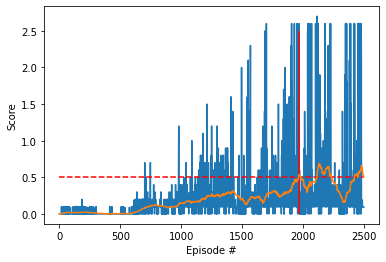

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hlines(0.5, 0, len(score_list), colors='red', linestyles='dashed', label='12 pts', zorder=15)
plt.vlines(1966, 0, 2.5, colors='red', linestyles='solid', label='12 pts', zorder=15)
plt.plot(np.arange(len(score_list)), score_list, zorder=5)
plt.plot(np.arange(len(score_list)), score_trailing_avg_list, zorder=20)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

---
# Replay Loop

In [ ]:
multi_agent = MultiAgent(state_size=state_size, action_size=action_size, buffer_size=10000, batch_size=256, gamma=0.99, learn_rate=0.0001)
multi_agent.load_weights("./checkpoints_torch")

def play(n_episodes=300):       
    score_list = []
    score_queue = deque(maxlen=100)
    score_trailing_avg_list = []

    for episode in range(0, n_episodes):
        ticks = 0
        scores = np.zeros( shape=(num_agents,) )

        env_info = env.reset(train_mode=False)[brain_name]   # Reset the environment
        states = env_info.vector_observations               # Get the current state

        multi_agent.reset() # Reset the noise process

        start = time.time()
        while True:
            # Select action according to policy:
            actions = multi_agent.action(states, episode, add_noise=False)
            #print (actions)
            env_info = env.step(actions)[brain_name]
            
            rewards = np.array( env_info.rewards )
            next_states = env_info.vector_observations
            dones = env_info.local_done

            scores += rewards
            states = next_states
            
            if np.any(dones):
                break

            ticks += 1

        end = time.time()

        # Only the agent with the max score counts per episode:
        score_max = np.max(scores)
        score_list.append(score_max)
        score_queue.append(score_max)

        score_trailing_avg = np.mean(score_queue)
        score_trailing_avg_list.append(score_trailing_avg)

        print("***********************************************")
        print("Maximum score of episode {}: {:.2f}".format(episode, score_max))
        print("Trailing avg. score: {:.2f}".format(score_trailing_avg))
        print("Time consumed: {:.2f} s".format(end-start))
        print("***********************************************")

        episode += 1

    return score_list, score_trailing_avg_list

In [ ]:
score_list, score_trailing_avg_list = play(300)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hlines(0.5, 0, len(score_list), colors='red', linestyles='dashed', label='12 pts', zorder=15)
plt.plot(np.arange(len(score_list)), score_list, zorder=5)
plt.plot(np.arange(len(score_list)), score_trailing_avg_list, zorder=20)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Close environment:

In [ ]:
env.close()